# <font color=blue> __Single-cell RNA-seq data analysis using SCANPY__  </font>

- 이 주피터 노트북은 단일세포 RNA-seq 데이터를 분석하기 위한 기초 실습을 포함합니다.
- SCANPY를 이용한 전처리, 시각화를 위한 기본적인 처리 과정에 대한 코드 예제를 제공합니다.
- Google Colab에서 실습하는 것을 가정하고 만들었으나 Anaconda 등이 설치된 개인 컴퓨터에서도 사용할 수 있습니다.

<br>

- __AnnData Format:__ https://anndata.readthedocs.io/en/stable/
- __SCANPY:__ https://scanpy.readthedocs.io/en/stable/

<br>

__MLBI-lab, July 21, 2025__

## __1. Install required packages and import them__
이제 파일이 준비되었으니 필요한 패키지를 설치하고 이를 불러와서(import해서) 데이터를 들여다 볼 수 있습니다.

In [ ]:
## 필요한 패키지 설치 (이미 설치되었다면 skip 해도 됩니다.)
'''
!pip install gdown
!pip install numpy
!pip install pandas
!pip install scipy
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn
!pip install scikit-network
'''
!pip install leidenalg
!pip install scanpy
!pip install scoda-viz==0.4.7
## This jupyter notebook was tested with the above version of scoda-viz package.

In [ ]:
## 필요한 패키지 불러오기
import copy, warnings, os
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scodaviz import load_sample_data, plot_sankey

warnings.filterwarnings('ignore')

https://github.com/combio-dku
INFO: statannotations was sucessfully installed.


## __2A. Download a sample data__

In [ ]:
adata = load_sample_data( 'BC' )
adata

Downloading...
From (original): https://drive.google.com/uc?export=download&id=158LUiHiJNFzYvqY-QzMUm5cvIznBrUAV
From (redirected): https://drive.google.com/uc?export=download&id=158LUiHiJNFzYvqY-QzMUm5cvIznBrUAV&confirm=t&uuid=280621e1-5816-4758-9e5a-e18591ddae3e
To: /content/downloaded
100%|██████████| 124M/124M [00:01<00:00, 109MB/s]


File saved to: BC.h5ad


AnnData object with n_obs × n_vars = 33742 × 22585
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'sid', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'subtype', 'subtype_detail', 'tissue', 'condition', 'sample', 'celltype_major', 'celltype_minor', 'celltype_subset'

## __2A. Or, Load your h5ad file__

In [ ]:
file_h5ad = 'BRCA_GSE161529_33K_v1.h5ad'

In [ ]:
adata = sc.read_h5ad(file_h5ad)
adata

AnnData object with n_obs × n_vars = 33742 × 22585
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'sid', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'subtype', 'subtype_detail', 'tissue', 'condition', 'sample', 'celltype_major', 'celltype_minor', 'celltype_subset'

#### This dataset contains several pieces of preprocessed information, which we remove to start from scratch.

In [ ]:
lst = ['n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sid',
       'tissue', 'celltype_major', 'celltype_minor', 'celltype_subset']
lst = list(set(lst).intersection(adata.obs.columns.values))
adata.obs.drop( columns = lst, inplace = True )
adata

AnnData object with n_obs × n_vars = 33742 × 22585
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample'

## __3. Check your data__

#### __AnnData Format:__
  
<div>
<img src="https://drive.google.com/uc?export=view&id=1IGjZpO_DeaNFiX3u_fy_rnPC1oKwVsqU" align="center" width="500"/>
</div>
<div>
<img src="attachment:fefeae20-ad05-4cea-8327-72f3dd19903f.png" width="500"/>
</div>

#### __Basic operations__
1. cell selection, gene selection (supports boolean indexing as for DataFrame)
3. writing to a file
4. getting cell-by-gene count matrix as a data frame
5. adding an annotation

In [ ]:
adata.obs.head()

In [ ]:
adata.var.head()

In [ ]:
adata.obs[['condition']].value_counts()

In [ ]:
adata.obs[['sample']].value_counts()

In [ ]:
lst = [adata.obs['condition'], adata.obs['sample']]
plot_sankey(lst, title=None, fs=12, WH=(400, 600), th=30, title_y=0.85 )

## __4. Filtering cells and genes__
#### __Get statistics for Cell/Gene filtering__

In [ ]:
adata

AnnData object with n_obs × n_vars = 33742 × 22585
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample'

In [ ]:
## select genes of which the name start with 'MT-', i.e., mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')
## Boolean values saved to the new column named, 'mt' in var

In [ ]:
## Check the number of mitochondrial genes
display(adata.var['mt'].sum())

np.int64(13)

In [ ]:
## Get stats
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt'], percent_top = None, \
                           log1p = False, inplace = True)

adata
## Results of this function are stored in new columns in the obs field

AnnData object with n_obs × n_vars = 33742 × 22585
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

pp.calculate_qc_metrics: https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.calculate_qc_metrics.html

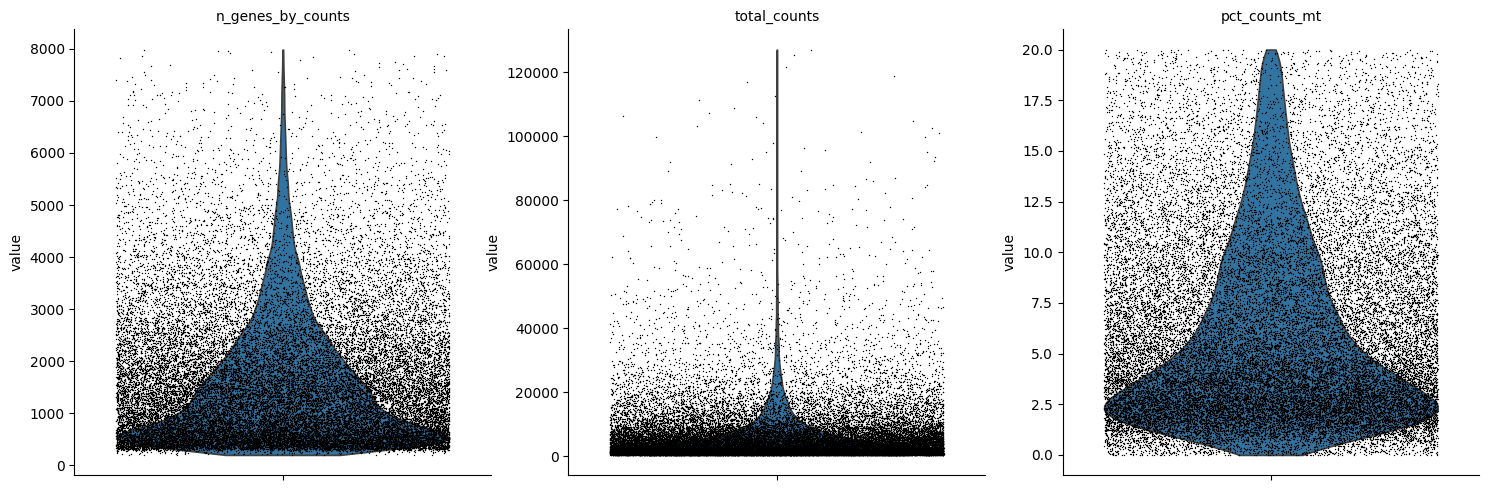

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [ ]:
adata.obs[['n_genes_by_counts', 'total_counts', 'pct_counts_mt']].median()

,0
n_genes_by_counts,1268.000000
total_counts,3516.000000
pct_counts_mt,4.536538


#### __Cell/Gene filtering__
- cell-by-gene count matrix에서 각 gene이 발현된 cell 수가 너무 적은 것은 제거
- 이를 위해 cell-by-gene count matrix를 data frame으로 가져와서
- 각 gene에 대해 0보다 큰 cell의 수를 계산하여
- 이 수를 기준으로 조건을 만들어서 filtering 함

#### Easy way to cell/gene filtering

In [ ]:
sc.pp.filter_cells(adata, min_genes = 200)
sc.pp.filter_cells(adata, max_genes = 4000)
sc.pp.filter_genes(adata, min_cells = 20)

adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

## __5. Basic processings__

#### 이후의 processing은 cell-by-gene count matrix의 값을 바꾸므로 raw count 값을 따로 저장해 놓음

In [ ]:
## adata의 raw count가 나중에 필요힐 수 있으므로 사본을 만들어서 adata.raw에 저장
# adata.raw = adata.copy()
## 나중에 adata 저장시 adata.raw도 같이 저장됨

adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

#### __2차원 시각화(UMAP 또는 tSNE)를 위한 몇 가지 routine 한 step__
1. Count normalization: 각 행의 합(각 cell에 대한 RNA count의 총합)을 동일한 값(예 10,000)으로 맞춤
2. 1-augmented log-transform: Raw count의 확률분포를 정규분포에 가깝게 변환 (log변환 전 1을 더함)
3. highly variable gene selection: cell마다 값들의 변동이 큰 gene들을 확인하여 var field의 열('variable_gene')에 저장
4. Dimension reduction using PCA: 선형변환 방식인 PCA를 이용하여 각 cell의 expression pattern(X의 각 행)을 차원 축소 -> obsm['X_pca']에 저장됨. (_Note:_ PCA를 위한 차원은 소위 'explained variance' plot을 보고 결정하면 좋지만 대략 15정도로 설정해도 무방함.)
5. Building Neighbor graph: PCA로 차원 축소한 벡터를 이용하여, 각 cell에 대해 expression pattern이 유사한 k개의 cell을 선택하여 이를 sparse matrix 형태로 저장 (matrix 크기는 cell수xcell수 이며 obsp field에 sparse matrix로 저장 됨.
6. UMAP or tSNE projection: Neighbor graph까지 얻어졌으면 umap 또는 tsne를 이용하여 2차원으로 차원 축소하여 산점도 확인 가능
7. Clustering: 비슷한 expression pattern을 갖는 cell들을 하나의 클러스터로 그룹핑

In [ ]:
## 1. Count normalization
sc.pp.normalize_total(adata, target_sum=1e4)
adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [ ]:
## 2. 1-augmented log-transform
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'

In [ ]:
## 3. highly variable gene selection
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)
adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

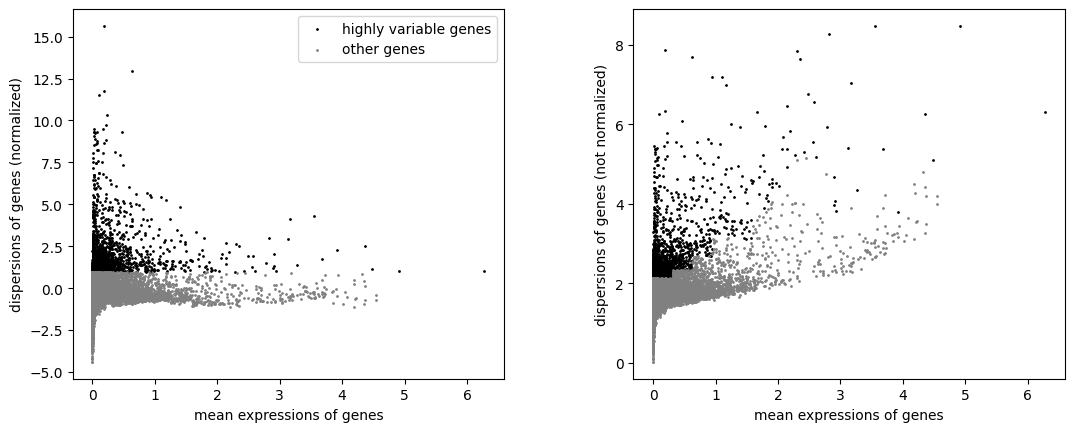

In [ ]:
## check stats of highly-variable genes
sc.pl.highly_variable_genes(adata)

In [ ]:
## 4. Dimension reduction using PCA
sc.tl.pca(adata, n_comps = 15, use_highly_variable = True)
adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [ ]:
## 5. Building Neighbor graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15, use_rep = 'X_pca')
adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
## 6a: Compute UMAP projection
sc.tl.umap(adata)
adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
## 6b: tSNE projection (It takes time)
sc.tl.tsne(adata)
adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'tsne'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
## 7: Clustering using leiden algorithm
sc.tl.leiden(adata, resolution = 0.2, key_added = 'cluster')
## The clustering resolution was intentionally set low for quick example. Default value is 1.
adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'cluster'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'tsne', 'cluster'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## __6. Visualization__

#### 이제 UMAP 또는 tSNE 좌표를 이용해 대체적인 분포를 시각화해 볼 수 있습니다.

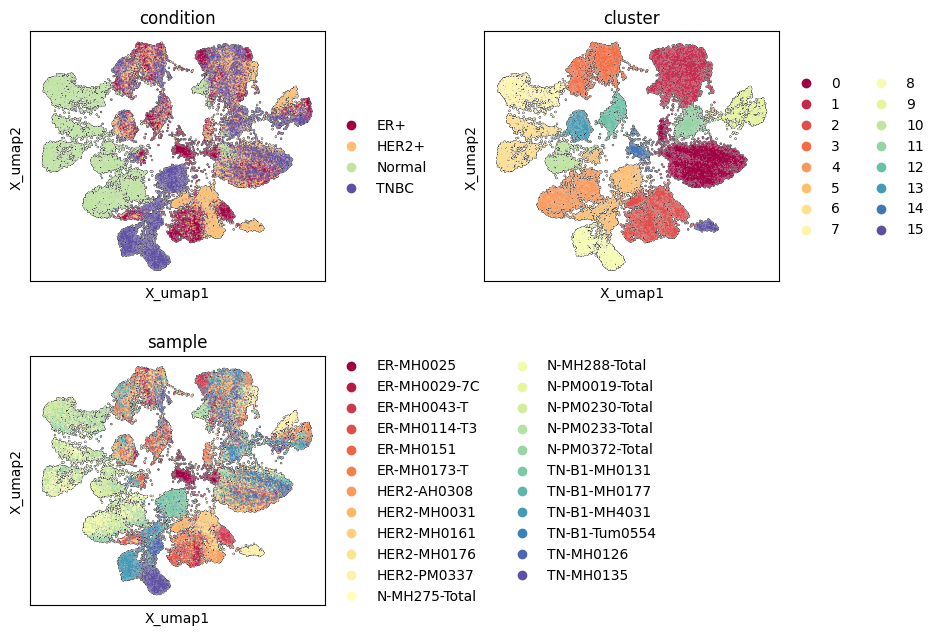

In [ ]:
items_to_plot = ['condition', 'cluster', 'sample']

plt.rcParams['figure.figsize'] = (3.5, 3.5)
sc.pl.embedding( adata, color = items_to_plot,
                 basis = 'X_umap', neighbors_key = 'neighbors',
                 wspace = 0.4, hspace = 0.3, legend_fontsize = 10,
                 ncols = 2, palette = 'Spectral', add_outline = True)

#### 잘 알려진 몇가지 marker gene들의 발현량을 보면 어느 cluster가 무슨 세포유형인지 대략적으로 확인 가능

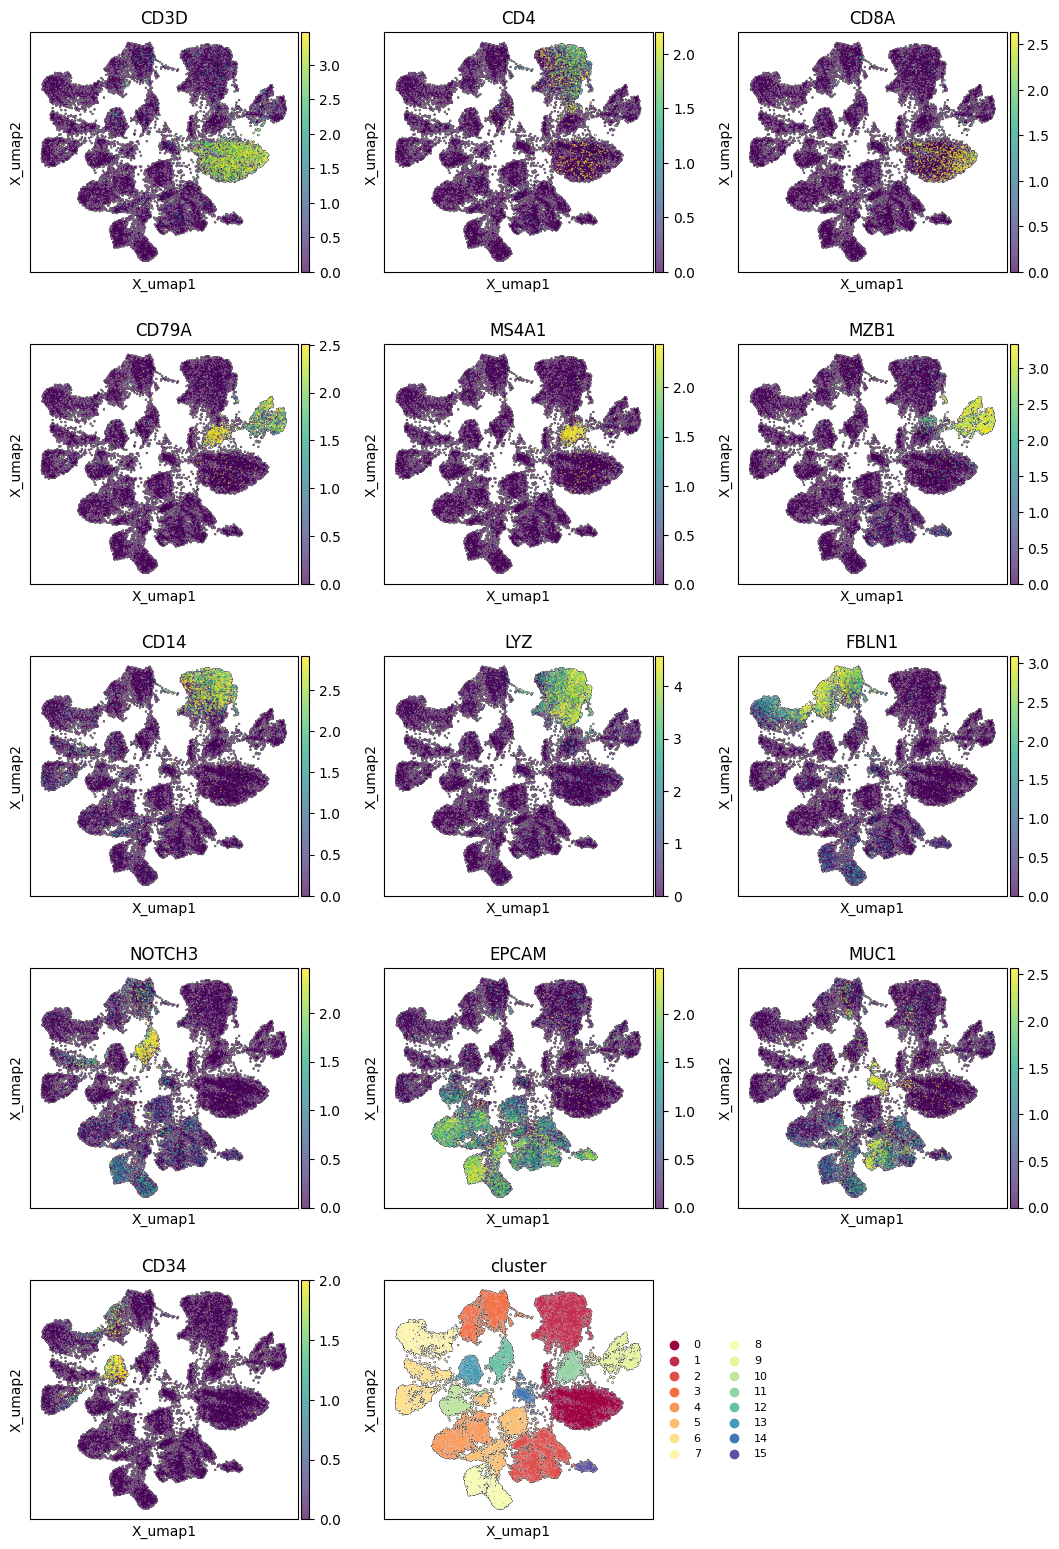

In [ ]:
items_to_plot = ['CD3D', 'CD4', 'CD8A',     ## T cell markers
                 'CD79A', 'MS4A1', 'MZB1',  ## B cell markers
                 'CD14', 'LYZ',             ## Myeloid cell markers
                 'FBLN1', 'NOTCH3',         ## Stromal cells (Fibroblast, Smooth muscle cell) markers
                 'EPCAM', 'MUC1',           ## Epithelial cell markers
                 'CD34']                    ## Endothelial cell marker


plt.rcParams['figure.figsize'] = (3.5, 3.5)
sc.pl.embedding( adata, color = items_to_plot + ['cluster'], use_raw = False,
                 basis = 'X_umap', neighbors_key = 'neighbors',
                 wspace = 0.2, hspace = 0.3, legend_fontsize = 8,
                 ncols = 3, palette = 'Spectral', add_outline = True, vmax = 'p99', vmin = 0)

#### Cluster 별 manual cell-type annotation을 할 때 요런 plot을 먼저 봅니다.

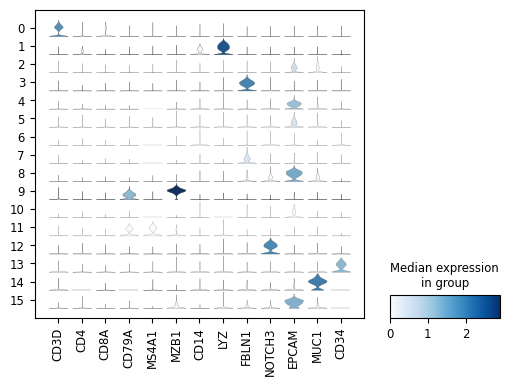

In [ ]:
sc.pl.stacked_violin(adata, items_to_plot, groupby='cluster', figsize = (6,4))

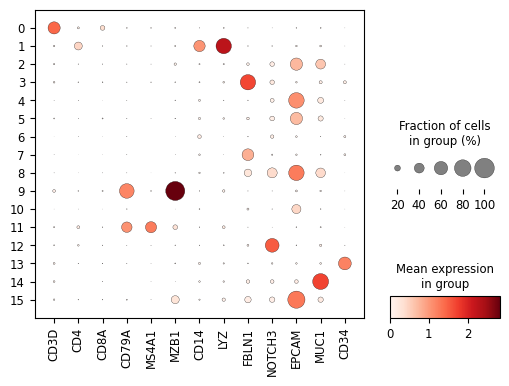

In [ ]:
sc.pl.dotplot(adata, items_to_plot, groupby='cluster', figsize = (6,4))

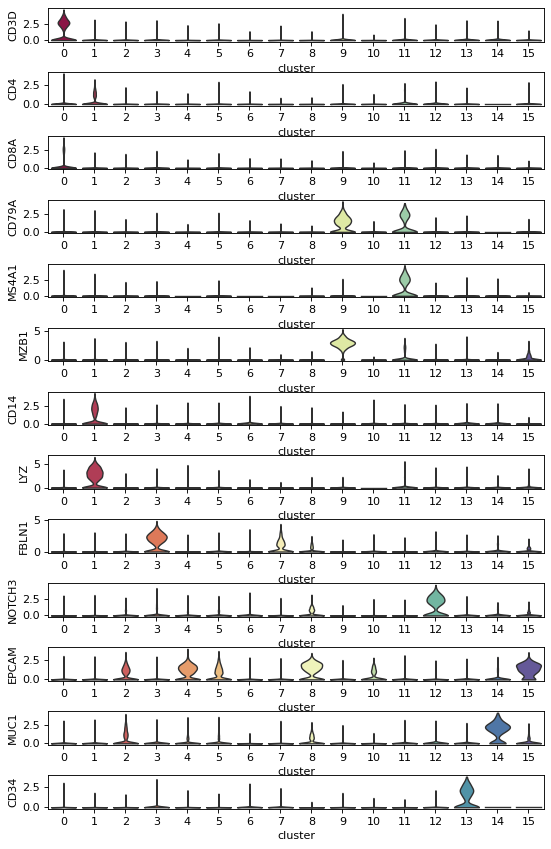

In [ ]:
fig, axes = plt.subplots(len(items_to_plot), 1, figsize=(8, 1*len(items_to_plot)), dpi = 80)
plt.subplots_adjust(hspace = 0.9)

for j, item in enumerate(items_to_plot):
    sc.pl.violin(adata, [item], groupby='cluster', ax = axes[j], use_raw = False, stripplot = False, show = False)

Unknown type for standard_scale, ignored


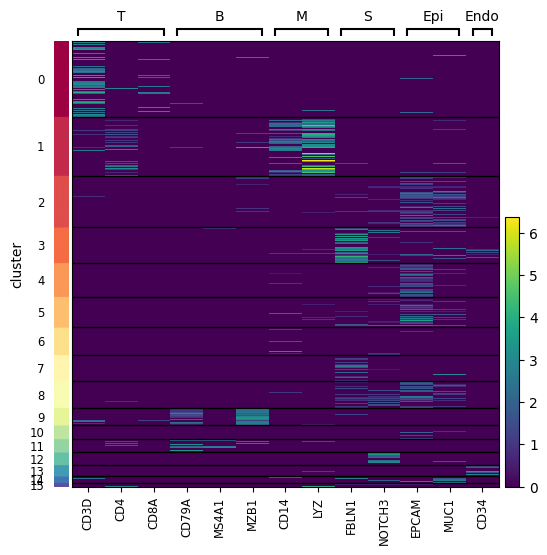

In [ ]:
items_to_plot = {'T': ['CD3D', 'CD4', 'CD8A'],     ## T cell markers
                 'B': ['CD79A', 'MS4A1', 'MZB1'],  ## B cell markers
                 'M': ['CD14', 'LYZ'],             ## Myeloid cell markers
                 'S': ['FBLN1', 'NOTCH3'],         ## Stromal cells (Fibroblast, Smooth muscle cell) markers
                 'Epi': ['EPCAM', 'MUC1'],           ## Epithelial cell markers
                 'Endo': ['CD34'] }                   ## Endothelial cell marker


sc.pl.heatmap( adata, var_names = items_to_plot, groupby = 'cluster',
               var_group_labels = items_to_plot.keys(),
               standard_scale = True, figsize = (6, 6) )

## __7. DEG Analysis (among clusters)__

In [ ]:
test_sel = 'wilcoxon'  ## 'logreg', 't-test', 'wilcoxon', 't-test_overestim_var'
sc.tl.rank_genes_groups(adata, groupby = 'cluster', method=test_sel,
                        key_added = test_sel, pts = True)
adata

AnnData object with n_obs × n_vars = 31676 × 20013
    obs: 'Patient', 'Description', 'Source', 'Condition', 'Menopause', 'Parity', 'Gender', 'geo_no', 'subtype', 'subtype_detail', 'condition', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'cluster'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'tsne', 'cluster', 'condition_colors', 'cluster_colors', 'sample_colors', 'wilcoxon'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

#### Get DEG results in data frame

In [ ]:
target_cluster = '0'
gene_rank = sc.get.rank_genes_groups_df(adata, group = target_cluster,
                                        key = test_sel, pval_cutoff = 0.01,
                                        log2fc_min = 0.25)

In [ ]:
gene_rank.iloc[:30]

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,B2M,85.394470,2.237318,0.0,0.0,0.996657,0.946978
1,TMSB4X,76.034843,2.331866,0.0,0.0,0.993500,0.932562
2,CD52,69.950180,4.926069,0.0,0.0,0.658867,0.093492
3,RPS27,68.605194,1.110349,0.0,0.0,0.992572,0.981591
4,BTG1,68.198204,2.385099,0.0,0.0,0.823770,0.669811
5,CXCR4,61.169422,3.766873,0.0,0.0,0.639183,0.206458
6,HLA-A,60.633606,1.818771,0.0,0.0,0.864067,0.752425
7,HLA-B,60.585011,1.797432,0.0,0.0,0.900093,0.778479
8,CD3D,59.599098,6.511799,0.0,0.0,0.527762,0.023430
9,IL32,57.042347,3.659792,0.0,0.0,0.598329,0.217717


In [ ]:
target_cluster = '1'
gene_rank = sc.get.rank_genes_groups_df(adata, group = target_cluster,
                                        key = test_sel, pval_cutoff = 0.01,
                                        log2fc_min = 0.25)

In [ ]:
gene_rank.iloc[:30]

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,TYROBP,95.800034,7.621763,0.0,0.0,0.934928,0.040515
1,HLA-DRA,93.913795,6.302898,0.0,0.0,0.948086,0.248509
2,FTL,93.855888,3.929819,0.0,0.0,0.997129,0.901295
3,CD74,93.496788,5.491233,0.0,0.0,0.964593,0.380855
4,FCER1G,88.775818,6.901947,0.0,0.0,0.873923,0.046698
5,HLA-DRB1,85.212151,5.312418,0.0,0.0,0.886842,0.214940
6,HLA-DPA1,83.252502,5.528394,0.0,0.0,0.855263,0.164242
7,HLA-DPB1,80.544807,5.297369,0.0,0.0,0.837081,0.177335
8,AIF1,80.073120,7.836012,0.0,0.0,0.776077,0.015857
9,PSAP,78.367683,3.529727,0.0,0.0,0.887560,0.485125
